# Stock Predictions

## Using LSTM in Keras with TensorFlow

_Deep Learning Nanodegree Program | Deployment Model_

---

## Step 1: Setting up the notebook

We begin by setting up all of the necessary bits required to run our notebook. To start that means loading all of the Python modules we will need.<br>
This notebook was created and tested on an **ml.m4.xlarge** notebook instance.

Now we'll import the **Python** libraries we'll need.

In [2]:
import pandas as pd # High-performance, easy-to-use data structures and data analysis tools for the Python
import numpy as np
import warnings # Built-in exceptions that represent warning categories
import matplotlib.pyplot as plt # Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments 
import seaborn as sns
from scipy import stats
import sklearn.preprocessing
# from keras.preprocessing.sequence import TimeseriesGenerator

# from keras.models import Sequential
# from keras import layers
# from keras.optimizers import Adam
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
# from keras.layers import TimeDistributed
# from keras.layers import Bidirectional


Now we'll configure the **Notebook** with what we'll need to make the developing experience better.

In [3]:
pd.options.display.float_format = '{:,.2f}'.format # Configure the decimal display options for the notebook
warnings.filterwarnings('ignore') # Du=isable the notebook warnings

## Step 2: Downloading the data

The dataset we are going to use is very popular among researchers in Natural Language Processing, usually referred to as the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/). It consists of movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either '**pos**itive', if the reviewer enjoyed the film, or '**neg**ative' otherwise.

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.

We begin by using some Jupyter Notebook magic to download and extract the dataset.

In [4]:
# Download information from a s3 bucket overwritten previous files
!wget https://investment-and-trading-udacity.s3-us-west-2.amazonaws.com/JPM+2009-2019.csv -O ../data/raw/JPM+2009-2019.csv

--2019-08-04 23:24:31--  https://investment-and-trading-udacity.s3-us-west-2.amazonaws.com/JPM+2009-2019.csv
Resolving investment-and-trading-udacity.s3-us-west-2.amazonaws.com (investment-and-trading-udacity.s3-us-west-2.amazonaws.com)... 52.218.209.209
Connecting to investment-and-trading-udacity.s3-us-west-2.amazonaws.com (investment-and-trading-udacity.s3-us-west-2.amazonaws.com)|52.218.209.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187676 (183K) [text/csv]
Saving to: ‘../data/raw/JPM+2009-2019.csv’

../data/raw/JPM+200 100%[===================>] 183.28K   894KB/s    in 0.2s    

2019-08-04 23:24:32 (894 KB/s) - ‘../data/raw/JPM+2009-2019.csv’ saved [187676/187676]



In [5]:
# Load the download information into a pandas dataframe
stock_data = pd.read_csv('../data/raw/JPM+2009-2019.csv') 

## Step 3: Dataset Exploration and Visualization

The data we have downloaded is split into various files, each of which contains a single review. It will be much easier going forward if we combine these individual files into two large files, one for training and one for testing.

In [6]:
print('Dataset dimensions: {}'.format(stock_data.shape))

Dataset dimensions: (2654, 7)


In [7]:
print('Minimun date: {} / Maximun date: {}'.format(stock_data.Date.min(), stock_data.Date.max()))

Minimun date: 2009-01-02 / Maximun date: 2019-07-19


In [8]:
print('Dataset Information...', '\n')
stock_data.info()

Dataset Information... 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2654 entries, 0 to 2653
Data columns (total 7 columns):
Date         2654 non-null object
Open         2654 non-null float64
High         2654 non-null float64
Low          2654 non-null float64
Close        2654 non-null float64
Adj Close    2654 non-null float64
Volume       2654 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 145.2+ KB


In [9]:
print('Summary of the first rows of the stock market dataset...', '\n')
stock_data.head()

Summary of the first rows of the stock market dataset... 



,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-02,31.19,31.64,30.47,31.35,24.56,32494900
1,2009-01-05,30.73,30.77,29.08,29.25,22.92,44069400
2,2009-01-06,29.79,30.42,29.51,29.88,23.41,44216300
3,2009-01-07,29.15,29.40,28.00,28.09,22.01,42156500
4,2009-01-08,27.90,27.95,26.86,27.22,21.33,52075800


In [10]:
print('Statistical analysis for stock market dataset...', '\n')
stock_data.describe()

Statistical analysis for stock market dataset... 



,Open,High,Low,Close,Adj Close,Volume
count,"2,654.00","2,654.00","2,654.00","2,654.00","2,654.00","2,654.00"
mean,62.13,62.72,61.53,62.13,55.72,"26,770,442.20"
std,25.80,25.91,25.69,25.79,27.44,"21,861,503.66"
min,15.37,17.29,14.96,15.90,12.46,"3,680,000.00"
25%,41.50,41.94,41.03,41.53,33.33,"13,436,550.00"
50%,56.62,57.00,56.14,56.67,49.27,"19,304,750.00"
75%,78.75,79.44,78.30,79.25,73.62,"32,481,600.00"
max,119.13,119.33,118.08,118.77,115.30,"217,294,200.00"


In [11]:
print('Data integrity validation...', '\n')
stock_data.isnull().sum()

Data integrity validation... 



Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

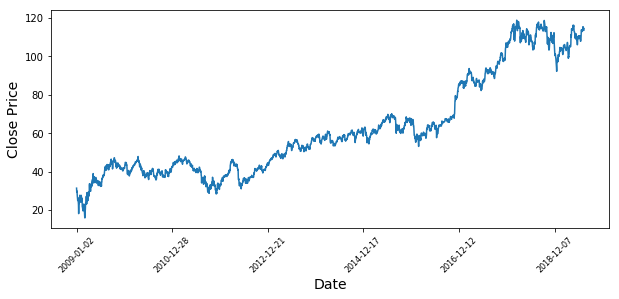

In [12]:
plt.figure(figsize = (10,4))
plt.plot(range(stock_data.shape[0]), stock_data['Close'])
plt.xticks(range(0, stock_data.shape[0], 500), stock_data['Date'].loc[::500], rotation = 45, fontsize = 8)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Close Price',fontsize = 14)
plt.show()

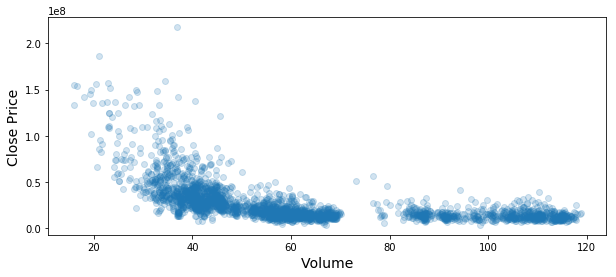

In [13]:
plt.figure(figsize = (10,4))
plt.scatter(stock_data.Close, stock_data.Volume, alpha = 0.2)
plt.xlabel('Volume', fontsize = 14)
plt.ylabel('Close Price',fontsize = 14)
plt.show()

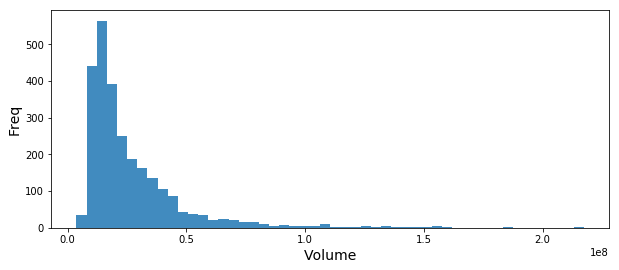

In [14]:
plt.figure(figsize = (10,4))
plt.hist(stock_data.Volume, bins = 50, alpha = 0.85)
plt.xlabel('Volume', fontsize = 14)
plt.ylabel('Freq',fontsize = 14)
plt.show()

## Step 4: Preprocessing the data / Feature Engineering

Now that we have our training and testing datasets merged and ready to use, we need to start processing the raw data into something that will be useable by our machine learning algorithm. To begin with, we remove any html formatting that may appear in the reviews and perform some standard natural language processing in order to homogenize the data.

In [15]:
def calculate_diff(df, list_inputs, list_offsets, prefix):
    '''Calculate multiple features based on the difference from previous data'''
    for feat in list_inputs:
        for offset in list_offsets:
            df[str(prefix) +'_'+ str(offset)] = df[feat].diff(offset)
    return df

In [16]:
stock_data_process = calculate_diff(stock_data, list_inputs = ['Volume'], list_offsets = [5,10,20,40,80,160], prefix = 'VDiff')

In [17]:
stock_data_process.head()

,Date,Open,High,Low,Close,Adj Close,Volume,VDiff_5,VDiff_10,VDiff_20,VDiff_40,VDiff_80,VDiff_160
0,2009-01-02,31.19,31.64,30.47,31.35,24.56,32494900,nan,nan,nan,nan,nan,nan
1,2009-01-05,30.73,30.77,29.08,29.25,22.92,44069400,nan,nan,nan,nan,nan,nan
2,2009-01-06,29.79,30.42,29.51,29.88,23.41,44216300,nan,nan,nan,nan,nan,nan
3,2009-01-07,29.15,29.40,28.00,28.09,22.01,42156500,nan,nan,nan,nan,nan,nan
4,2009-01-08,27.90,27.95,26.86,27.22,21.33,52075800,nan,nan,nan,nan,nan,nan


In [18]:
def calculate_me(df, list_inputs, list_offsets, prefix):
    '''Calculate the moving average for the selected variable'''
    for feat in list_inputs:
        for offset in list_offsets:
            df[str(prefix) +'_'+ str(offset)] = df[feat].rolling(offset).mean()
    return df

In [19]:
stock_data_process = calculate_me(stock_data_process, list_inputs = ['Close'], list_offsets = [5,10,20,40,80,160], prefix = 'MA')

In [20]:
stock_data_process.head()

,Date,Open,High,Low,Close,Adj Close,Volume,VDiff_5,VDiff_10,VDiff_20,VDiff_40,VDiff_80,VDiff_160,MA_5,MA_10,MA_20,MA_40,MA_80,MA_160
0,2009-01-02,31.19,31.64,30.47,31.35,24.56,32494900,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,2009-01-05,30.73,30.77,29.08,29.25,22.92,44069400,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2009-01-06,29.79,30.42,29.51,29.88,23.41,44216300,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,2009-01-07,29.15,29.40,28.00,28.09,22.01,42156500,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,2009-01-08,27.90,27.95,26.86,27.22,21.33,52075800,nan,nan,nan,nan,nan,nan,29.16,nan,nan,nan,nan,nan


In [21]:
def calculate_ratios(df, numerators, denominators):
    '''Calculate ratio of the selected variables'''
    for num in numerators:
        for den in denominators:
            df[str(num) +'/'+str(den)] = df[num] / df[den]
    return df


In [22]:
stock_data_process = calculate_ratios(stock_data_process, numerators = ['Open'], denominators = ['Close'])

In [23]:
stock_data_process.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,VDiff_5,VDiff_10,VDiff_20,VDiff_40,VDiff_80,VDiff_160,MA_5,MA_10,MA_20,MA_40,MA_80,MA_160,Open/Close
0,2009-01-02,31.19,31.64,30.47,31.35,24.56,32494900,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.99
1,2009-01-05,30.73,30.77,29.08,29.25,22.92,44069400,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.05
2,2009-01-06,29.79,30.42,29.51,29.88,23.41,44216300,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00
3,2009-01-07,29.15,29.40,28.00,28.09,22.01,42156500,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.04
4,2009-01-08,27.90,27.95,26.86,27.22,21.33,52075800,nan,nan,nan,nan,nan,nan,29.16,nan,nan,nan,nan,nan,1.02
5,2009-01-09,27.55,27.55,25.81,25.97,20.35,42597500,"10,102,600.00",nan,nan,nan,nan,nan,28.08,nan,nan,nan,nan,nan,1.06
6,2009-01-12,25.92,26.15,24.50,24.91,19.52,59360000,"15,290,600.00",nan,nan,nan,nan,nan,27.21,nan,nan,nan,nan,nan,1.04
7,2009-01-13,25.21,26.59,24.27,26.35,20.65,73422800,"29,206,500.00",nan,nan,nan,nan,nan,26.51,nan,nan,nan,nan,nan,0.96
8,2009-01-14,25.59,26.28,24.76,25.91,20.30,73907300,"31,750,800.00",nan,nan,nan,nan,nan,26.07,nan,nan,nan,nan,nan,0.99
9,2009-01-15,26.54,27.05,23.76,24.34,19.07,136759300,"84,683,500.00",nan,nan,nan,nan,nan,25.50,27.33,nan,nan,nan,nan,1.09


In [24]:
def remove_errors(df):
    '''Remove NaNs from the dataset, created by the lag features'''
    df = df.dropna()
    return df

In [25]:
stock_data_process = remove_errors(stock_data_process)

In [26]:
def normalize_data(df, avoid_list, target):
    '''Min-Max Scaler normalization function'''
    temp = df.copy()
    for feat in temp.columns:
        if feat not in avoid_list:
            min_max_scaler = sklearn.preprocessing.MinMaxScaler()
            temp[feat] = min_max_scaler.fit_transform(temp[feat].values.reshape(-1,1))
            if feat == target:
                print('Saving scaler parameters for inverse calculations...')
                scaler = min_max_scaler
    print('Done...')
    return temp, scaler

In [27]:
avoid_list = ['Date']
stock_data_normalized, scaler = normalize_data(stock_data_process, avoid_list = avoid_list, target = 'Close')

Saving scaler parameters for inverse calculations...
Done...


In [28]:
stock_data_normalized.head()

,Date,Open,High,Low,Close,Adj Close,Volume,VDiff_5,VDiff_10,VDiff_20,VDiff_40,VDiff_80,VDiff_160,MA_5,MA_10,MA_20,MA_40,MA_80,MA_160,Open/Close
160,2009-08-21,0.16,0.16,0.16,0.17,0.12,0.18,0.43,0.44,0.54,0.49,0.44,0.62,0.15,0.14,0.12,0.07,0.05,0.00,0.41
161,2009-08-24,0.17,0.17,0.17,0.16,0.12,0.17,0.42,0.49,0.55,0.52,0.41,0.57,0.15,0.14,0.12,0.07,0.05,0.00,0.68
162,2009-08-25,0.17,0.17,0.17,0.17,0.12,0.15,0.44,0.45,0.54,0.53,0.47,0.56,0.16,0.15,0.12,0.08,0.06,0.00,0.51
163,2009-08-26,0.17,0.16,0.17,0.17,0.12,0.13,0.43,0.47,0.52,0.51,0.37,0.55,0.16,0.15,0.13,0.08,0.06,0.00,0.56
164,2009-08-27,0.16,0.16,0.16,0.17,0.12,0.12,0.42,0.47,0.49,0.51,0.46,0.51,0.16,0.15,0.13,0.08,0.06,0.00,0.48


## Step 5: Preparing and splitting the data Keras Model

Given that this is clean tabular data, we don't need to do any processing. However, we do need to split the rows in the dataset up into train, test and validation sets.

In [29]:
def conver_to_array(df, list_features, target):
    '''Convert a dataframe into a numpy array to train the model'''
    temp = df[target + list_features]
    float_data = temp.as_matrix()
    return float_data

In [30]:
input_list = ['Open','High','Low','Close','Adj Close','Volume','VDiff_5','VDiff_10','VDiff_20','VDiff_40','VDiff_80','VDiff_160','MA_5','MA_10','MA_20','MA_40','MA_80','MA_160','Open/Close']
data = conver_to_array(stock_data_normalized, list_features = input_list, target = ['Close'])

In [31]:
# Indexes train, validation and test datasets
train_percentage = 0.80
val_percentage = 0.10
test_percentage = 1.0 - (train_percentage + val_percentage)

min_train_idx, max_train_idx = 0, int(stock_data.shape[0] * train_percentage)
min_val_idx, max_val_idx = max_train_idx + 1, max_train_idx + int(stock_data.shape[0] * val_percentage)
min_test_idx, max_test_idx = max_val_idx + 1,  stock_data.shape[0] 

print('Min: {}    / Max: {} Train Indexes'.format(min_train_idx, max_train_idx))
print('Min: {} / Max: {} Validation Indexes'.format(min_val_idx, max_val_idx))
print('Min: {} / Max: {} Test Indexes'.format(min_test_idx, max_test_idx))

Min: 0    / Max: 2123 Train Indexes
Min: 2124 / Max: 2388 Validation Indexes
Min: 2389 / Max: 2654 Test Indexes


In [32]:
train_data = data[min_train_idx: max_train_idx]
validation_data = data[min_val_idx: max_val_idx]
test_data = data[min_test_idx: max_test_idx]
print('Train size: {} / Validation size: {} / Test size: {}'.format(train_data.shape[0], validation_data.shape[0], test_data.shape[0]))

Train size: 2123 / Validation size: 264 / Test size: 105


In [35]:
N_INPUTS = 30
BATCH_SIZE = 16
TEST_BATCH_SIZE = 1

train_generator = TimeseriesGenerator(train_data, train_data[:,0], length = N_INPUTS, batch_size = BATCH_SIZE)
val_generator = TimeseriesGenerator(validation_data, validation_data[:,0], length = N_INPUTS, batch_size = TEST_BATCH_SIZE)

train_steps = len(train_generator)
val_steps = len(val_generator)
print('Train generator steps: {}'.format(train_steps))
print('Validation generator steps: {}'.format(val_steps))

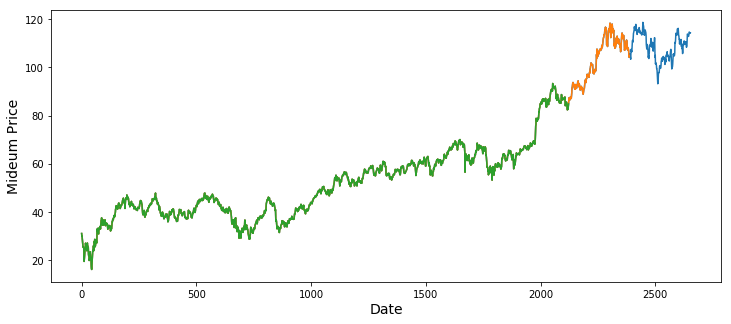

In [36]:
plt.figure(figsize = (12,5))
plt.plot(range(stock_data[min_train_idx:max_test_idx].shape[0]), (stock_data['Low'][min_train_idx:max_test_idx] + stock_data['High'][min_train_idx:max_test_idx]) / 2.0)
plt.plot(range(stock_data[min_train_idx:max_val_idx].shape[0]), (stock_data['Low'][min_train_idx:max_val_idx] + stock_data['High'][min_train_idx:max_val_idx]) / 2.0)
plt.plot(range(stock_data[min_train_idx:max_train_idx].shape[0]), (stock_data['Low'][min_train_idx:max_train_idx] + stock_data['High'][min_train_idx:max_train_idx]) / 2.0)
#plt.xticks(range(0, stock_data.shape[0], 500), stock_data['Date'].loc[::500], rotation = 45, fontsize = 8)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Mideum Price',fontsize = 14)
plt.show()

## Step 5: Preparing and splitting the data Pythorch Model

Given that this is clean tabular data, we don't need to do any processing. However, we do need to split the rows in the dataset up into train, test and validation sets.

### Building the Dataset with Pythorch

In [91]:
def create_dataset(dataset, look_back=1, forecast_horizon=1, batch_size=1):
    batch_x, batch_y, batch_z = [], [], []
    for i in range(0, len(dataset)-look_back-forecast_horizon-batch_size+1, batch_size):
        for n in range(batch_size):            
            x = dataset[['Close','Open']].values[i+n:(i + n + look_back), :]
            offset = x[0, 0]
            y = dataset['Close'].values[i + n + look_back:i + n + look_back + forecast_horizon]
            batch_x.append(np.array(x).reshape(look_back, -1))
            batch_y.append(np.array(y))
            batch_z.append(np.array(offset))
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        batch_z = np.array(batch_z)
        batch_x[:, :, 0] -= batch_z.reshape(-1, 1)
        batch_y -= batch_z.reshape(-1, 1)
        yield batch_x, batch_y, batch_z
        batch_x, batch_y, batch_z = [], [], []

In [92]:
train_samples = create_dataset(stock_data, look_back = 3, forecast_horizon = 1, batch_size = 3)

In [93]:
next(train_samples)

(array([[[ 0.      , 31.190001],
         [-2.1     , 30.73    ],
         [-1.470001, 29.790001]],
 
        [[ 0.      , 30.73    ],
         [ 0.629999, 29.790001],
         [-1.16    , 29.15    ]],
 
        [[ 0.      , 29.790001],
         [-1.789999, 29.15    ],
         [-2.66    , 27.9     ]]]), array([[-3.26    ],
        [-2.030001],
        [-3.91    ]]), array([31.35    , 29.25    , 29.879999]))

## Step 6: Computing the common-sense, non-machine learning baseline

Now that we have the training and validation data uploaded to S3, we can construct our XGBoost model and train it. We will be making use of the high level SageMaker API to do this which will make the resulting code a little easier to read at the cost of some flexibility.

To construct an estimator, the object which we wish to train, we need to provide the location of a container which contains the training code. Since we are using a built in algorithm this container is provided by Amazon. However, the full name of the container is a bit lengthy and depends on the region that we are operating in. Fortunately, SageMaker provides a useful utility method called `get_image_uri` that constructs the image name for us.

To use the `get_image_uri` method we need to provide it with our current region, which can be obtained from the session object, and the name of the algorithm we wish to use. In this notebook we will be using XGBoost however you could try another algorithm if you wish. The list of built in algorithms can be found in the list of [Common Parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).


In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = (val_generator[step])
        preds = samples[:, -1, 0]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return (np.mean(batch_maes))
    

mean_absolute_error = evaluate_naive_method()
print(mean_absolute_error)

## Step 7: Uploading the training and validation files to S3

When a training job is constructed using SageMaker, a container is executed which performs the training operation. This container is given access to data that is stored in S3. This means that we need to upload the data we want to use for training to S3. We can use the SageMaker API to do this and hide some of the details.

### Save the data locally

First we need to create the train and validation csv files which we will then upload to S3.



In [ ]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [ ]:
# We use pandas to save our train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, it is assumed
# that the first entry in each row is the target variable.

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Upload the data to a S3 bucket

Since we are currently running inside of a SageMaker session, we can use the object which represents this session to upload our data to the 'default' S3 bucket. Note that it is good practice to provide a custom prefix (essentially an S3 folder) to make sure that you don't accidentally interfere with data uploaded from some other notebook or project.

In [ ]:
prefix = 'boston-xgboost-deploy-ll'

val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## Step 8: Train and construct the Keras model

Now that we have the training and validation data uploaded to S3, we can construct a training job for our XGBoost model and build the model itself.

### Set up the training job

First, we will set up and execute a training job for our model. To do this we need to specify some information that SageMaker will use to set up and properly execute the computation. For additional documentation on constructing a training job, see the [CreateTrainingJob API](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTrainingJob.html) reference.

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(32, activation = 'relu', dropout = 0.0, recurrent_dropout = 0.0, return_sequences = True), input_shape = (None, train_data.shape[-1])))
model.add(Bidirectional(LSTM(8, activation = 'relu', dropout = 0.0, recurrent_dropout = 0.0)))
model.add(layers.Dense(1))

model.compile(optimizer = Adam(lr = 0.0025, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.001, amsgrad = False), loss = 'mae')

history = model.fit_generator(train_generator,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_generator,
                              validation_steps = len(val_generator))

### Creating Estimators in tf.estimator with Keras

This tutorial covers how to create your own training script using the building blocks provided in tf.keras, which will predict the ages of abalones based on their physical measurements. You'll learn how to do the following:

* Construct a custom model function
* Configure a neural network using tf.keras
* Choose an appropriate loss function from tf.losses
* Define a training op for your model
* Generate and return predictions

### An Abalone Age Predictor

It's possible to estimate the age of an
[abalone](https://en.wikipedia.org/wiki/Abalone) (sea snail) by the number of
rings on its shell. However, because this task requires cutting, staining, and
viewing the shell under a microscope, it's desirable to find other measurements
that can predict age.

The [Abalone Data Set](https://archive.ics.uci.edu/ml/datasets/Abalone) contains
the following
[feature data](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names)
for abalone:

| Feature        | Description                                               |
| -------------- | --------------------------------------------------------- |
| Length         | Length of abalone (in longest direction; in mm)           |
| Diameter       | Diameter of abalone (measurement perpendicular to length; in mm)|
| Height         | Height of abalone (with its meat inside shell; in mm)     |
| Whole Weight   | Weight of entire abalone (in grams)                       |
| Shucked Weight | Weight of abalone meat only (in grams)                    |
| Viscera Weight | Gut weight of abalone (in grams), after bleeding          |
| Shell Weight   | Weight of dried abalone shell (in grams)                  |
| Shell Weight   | Weight of dried abalone shell (in grams)                  |
| Shell Weight   | Weight of dried abalone shell (in grams)                  |
| Shell Weight   | Weight of dried abalone shell (in grams)                  |
| Shell Weight   | Weight of dried abalone shell (in grams)                  |
| Shell Weight   | Weight of dried abalone shell (in grams)                  |
| Shell Weight   | Weight of dried abalone shell (in grams)                  |
| Shell Weight   | Weight of dried abalone shell (in grams)                  |
| Shell Weight   | Weight of dried abalone shell (in grams)                  |
| Shell Weight   | Weight of dried abalone shell (in grams)                  |
| Shell Weight   | Weight of dried abalone shell (in grams)                  |
| Shell Weight   | Weight of dried abalone shell (in grams)                  |


The label to predict is number of rings, as a proxy for abalone age.

## Step 9: Train and construct the Pythorch model

Now that we have the training and validation data uploaded to S3, we can construct a training job for our XGBoost model and build the model itself.

### Set up the training job

First, we will set up and execute a training job for our model. To do this we need to specify some information that SageMaker will use to set up and properly execute the computation. For additional documentation on constructing a training job, see the [CreateTrainingJob API](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTrainingJob.html) reference.

In [117]:
def create_dataset(dataset, look_back=1, forecast_horizon=1, batch_size=1):
    batch_x, batch_y, batch_z = [], [], []
    for i in range(0, len(dataset)-look_back-forecast_horizon-batch_size+1, batch_size):
        for n in range(batch_size):            
            x = dataset[['Close','Open']].values[i+n:(i + n + look_back), :]
            offset = x[0, 0]
            y = dataset['Close'].values[i + n + look_back:i + n + look_back + forecast_horizon]
            batch_x.append(np.array(x).reshape(look_back, -1))
            batch_y.append(np.array(y))
            batch_z.append(np.array(offset))
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        batch_z = np.array(batch_z)
        batch_x[:, :, 0] -= batch_z.reshape(-1, 1)
        batch_y -= batch_z.reshape(-1, 1)
        yield batch_x, batch_y
        batch_x, batch_y, batch_z = [], [], []

In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Model(nn.Module):
    def __init__(self, config):
        super(Model, self).__init__()
        self.hidden_size = 128
        self.bi = 1
        self.lstm = nn.LSTM(config.get('features'),self.hidden_size,1,dropout=0.1,bidirectional=self.bi-1,batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size,self.hidden_size // 4,1,dropout=0.1,bidirectional=self.bi-1,batch_first=True)
        self.dense = nn.Linear(self.hidden_size // 4, config.get('forecast_horizon'))
        self.loss_fn = nn.MSELoss()
        
    def forward(self, x, batch_size = 32):
        hidden = self.init_hidden(batch_size)
        output, _ = self.lstm(x, hidden)
        output = F.dropout(output, p=0.5, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        output = F.dropout(output, p=0.5, training=True)
        output = self.dense(state[0].squeeze(0))
        
        return output
        
    def init_hidden(self, batch_size):
        h0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size))
        c0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size))
        return h0, c0
    
    def init_hidden2(self, batch_size):
        h0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size//4))
        c0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size//4))
        return h0, c0
    
    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

In [119]:
batch_size = 1
forecast_horizon = 1
look_back = 10
model = Model(dict(features = 2, forecast_horizon = 1))
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
n_epochs = 3

model.train()
train_true_y = []
train_pred_y = []

for epoch in range(n_epochs):
    ep_loss = []
    for i, batch in enumerate(create_dataset(stock_data_normalized, look_back = look_back, forecast_horizon = 1, batch_size = batch_size)):
        print("[{}{}] Epoch {}: loss={:0.4f}".format("-"*(20*i//(len(stock_data_normalized)//batch_size)), " "*(20-(20*i//(len(stock_data_normalized)//batch_size))),epoch, np.mean(ep_loss)), end="\r")
        try:
            batch = [torch.Tensor(x) for x in batch]
        except:
            break

        out = model.forward(batch[0].float(), batch_size)
        loss = model.loss(out, batch[1].float())
        if epoch == n_epochs - 1:
            train_true_y.append((batch[1] + batch[2]).detach().numpy().reshape(-1))
            train_pred_y.append((out + batch[2]).detach().numpy().reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ep_loss.append(loss.item())
    print()

[[[ 0.          0.16076146]
  [-0.00719108  0.17176498]
  [-0.00088503  0.1665933 ]
  [-0.00398275  0.1665933 ]
  [-0.00232325  0.16285211]
  [-0.00818677  0.17121481]
  [-0.00221265  0.15613996]
  [-0.02201573  0.16318225]
  [-0.03097687  0.14590667]
  [-0.0171479   0.14282571]]]
..................................................


TypeError: lstm() received an invalid combination of arguments - got (Tensor, tuple, list, bool, int, float, bool, int, bool), but expected one of:
 * (Tensor data, Tensor batch_sizes, tuple of Tensors hx, tuple of Tensors params, bool has_biases, int num_layers, float dropout, bool train, bool bidirectional)
      didn't match because some of the arguments have invalid types: (Tensor, !tuple!, !list!, !bool!, !int!, !float!, !bool!, !int!, bool)
 * (Tensor input, tuple of Tensors hx, tuple of Tensors params, bool has_biases, int num_layers, float dropout, bool train, bool bidirectional, bool batch_first)
      didn't match because some of the arguments have invalid types: (Tensor, !tuple!, !list!, bool, int, float, bool, !int!, bool)
